# Product Clustering

**Goal**: Starting from a collection of markets along with their *product instances* (that's how we'll call products as they appear in a market, e.g. "Azeite Andorinha 500ml" or "Azeite de Oliva Andorinha 0,5L"), we want to combine equivalent products instances into a *product type*. **We may assume the product instances were already tagged by our NER model**

**Choosing a clustering algorithm:** \
We want to:
- avoid algorithms with prefixed numbers of clusters (since it is variable)
- avoid algorithms that take toooo long
- use algorithms that accept a graph or a custom metric as input (since we are dealing with strings, not with N-dimensional points in euclidian space)
**Some interesting candidates:**
- [~~Agglomerative Clustering with single-linkage~~](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) --> too much memory
    - use the `connectivity` argument in sklearn implamentation to avoid clusters withins same market
    - do not use `n_clusters` (consequently, it is mandatory to set `distance_threshold`)
- [~~OPTICS~~](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html#sklearn.cluster.OPTICS) --> too slow
- [Affinity Propagation](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation)

**Or we try our own heuristic** 

## loading data

In [1]:
import os
import json

In [2]:
TAGGED_DATA_DIR = os.path.join("data", "tagged")
assert os.path.isdir(TAGGED_DATA_DIR), f"You must run predict.ipynb before to have tagged data in {TAGGED_DATA_DIR}"

In [3]:
data = {}  # map ID[int] : tagged product instance[dict]
id2market = {}  # map ID[int] : market we took product instance from[str]
market2id = {} # map market we took product instance from[str] : list of IDs
i = 0
for fname in os.listdir(TAGGED_DATA_DIR):
    with open(os.path.join(TAGGED_DATA_DIR, fname), "r") as f:
        products = json.load(f)
        for prod in products:
            data[i] = prod
            id2market[i] = fname
            if fname not in market2id: 
                market2id[fname] = []
            market2id[fname].append(i)
            i += 1

print(len(data))
print(len(id2market))
print(len(market2id))
print(data[73])


42581
42581
5
{'product': 'Combo 3x Brilhante 900ml', 'tags': {'product': ['Brilhante'], 'size': ['900ml']}}


In [4]:
texts = []  # raw texts of products
for _, v in sorted(data.items()):
    texts.append(v['product'])

print(texts[73])

Combo 3x Brilhante 900ml


## ~~distance/affinity functions~~ (maybe to use later)

In [5]:
from thefuzz import fuzz  # string similarities
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# some clustering algorithms in sklearn use distances (e.g. agglomerative, OPTICS)
# others use affinity (e.g. afifnity propagation)

def similarity(tags1, tags2):
    combined_score = 1
    n_scores = 0
    for label in ["product", "brand", "features", "size", "quantity"]:
        if label not in tags1 and label not in tags2:
            continue # ignore labels absent from both tag sets (uninformative)
        if label not in tags1 or label not in tags2:
            combined_score = 0
            n_scores += 1
        else:
            label_score = fuzz.token_set_ratio(tags1[label], tags2[label])
            label_score /= 100  # fuzz returns value in 0-100 range
            combined_score *= label_score
            n_scores += 1
    return combined_score ** (1 / n_scores)

def distance(tags1, tags2):
    return 1 - similarity(tags1, tags2)

In [7]:
fuzz.token_set_ratio(["aa", "b"], ["aba"])

57

some tests on the similarity function

<Axes: >

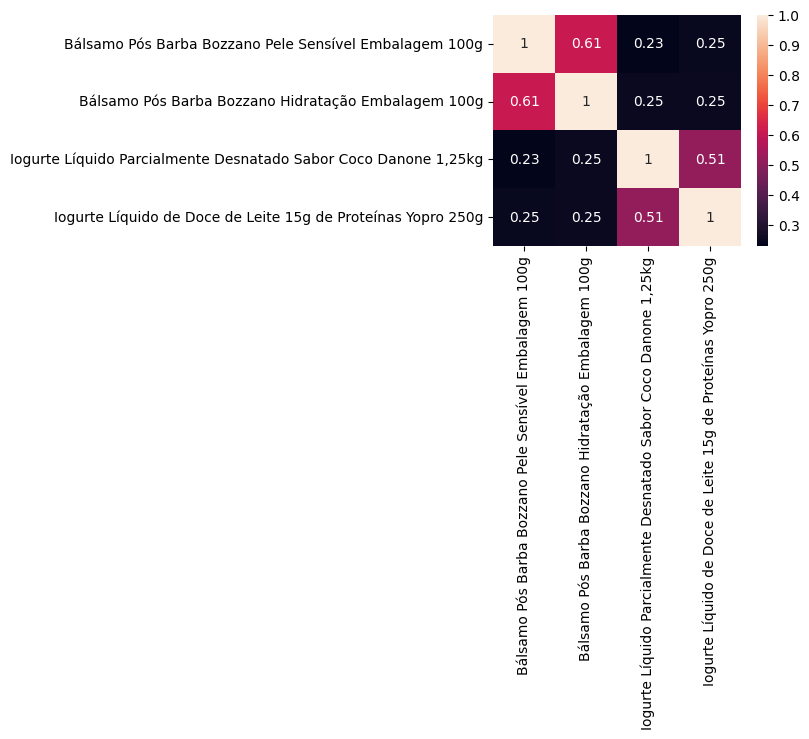

In [8]:
tags_set_morumbi = [ # coop---jd-morumbi-jd-morumbi.json
    # "Bálsamo Pós Barba Bozzano Pele Sensível Embalagem 100g"
    {"product": ["Bálsamo"], "brand": ["Pós Barba"], "features": ["Bozzano", "Pele", "Sensível"], "size": ["100g"]},
    # "Bálsamo Pós Barba Bozzano Hidratação Embalagem 100g"
    {"product": ["Bálsamo"], "brand": ["Pós Barba", "Bozzano"], "features": ["Hidratação"], "size": ["100g"]},
    # "Iogurte Líquido Parcialmente Desnatado Sabor Coco Danone 1,25kg"
    {"product": ["Iogurte"], "features": ["Líquido", "Parcialmente", "Desnatado", "Coco"], "brand": ["Danone"], "size": ["1,25kg"]},
    # "Iogurte Líquido de Doce de Leite 15g de Proteínas Yopro 250g"
    {"product": ["Iogurte"], "features": ["Líquido", "Doce de Leite", "Proteínas"], "size": ["15g", "250g"], "brand": ["Yopro"]}
]

labels = [
    "Bálsamo Pós Barba Bozzano Pele Sensível Embalagem 100g",
    "Bálsamo Pós Barba Bozzano Hidratação Embalagem 100g",
    "Iogurte Líquido Parcialmente Desnatado Sabor Coco Danone 1,25kg",
    "Iogurte Líquido de Doce de Leite 15g de Proteínas Yopro 250g"
]

similarity_matrix_example = np.array(
    [
        [similarity(tags1, tags2) for tags2 in tags_set_morumbi]
        for tags1 in tags_set_morumbi
    ]
)

fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(similarity_matrix_example, annot=True, xticklabels = labels, yticklabels=labels, ax=ax)

## Build similarity matrix with rapidfuzz

In [9]:
from rapidfuzz import process, fuzz
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
%%time
sim_matrix = process.cdist(texts, texts, dtype=np.int8, workers=8)

CPU times: total: 2min 37s
Wall time: 28.8 s


<span style="color:red">ATTENTION: similarities are in the range 0-100</span> (forgetting it prooved to be a common source of bugs for me...)

😀😀😀😀😀😀😀😀😀😀😀😀

In [11]:
sim_matrix.shape

(42581, 42581)

## visualize similarity matrix

In [12]:
random_ids = np.random.choice(len(data), 3)
# we got 3 random elements, now we got 1 element similar to each of those so 
# we can check if the similarity is meaningful in both cases
to_add = []
for id1 in random_ids:
    close_elem = np.argsort(sim_matrix[id1])[-5]
    to_add.append(close_elem)
random_ids = random_ids.tolist() + to_add
random_ids

[10254, 28345, 31232, 14186, 28349, 5518]

c:\Users\danie\miniconda3\envs\csi28\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\danie\miniconda3\envs\csi28\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

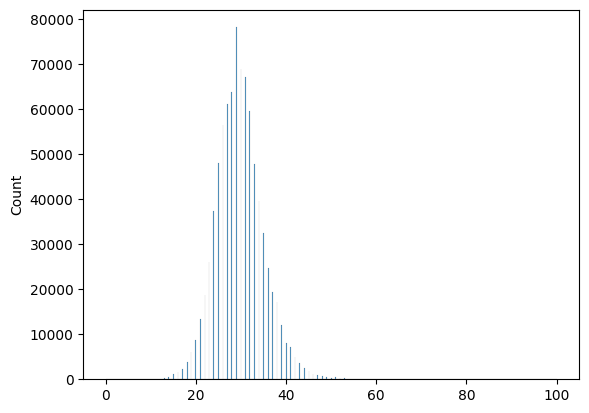

In [13]:
sns.histplot(x = sim_matrix[:20].flatten())

<Axes: >

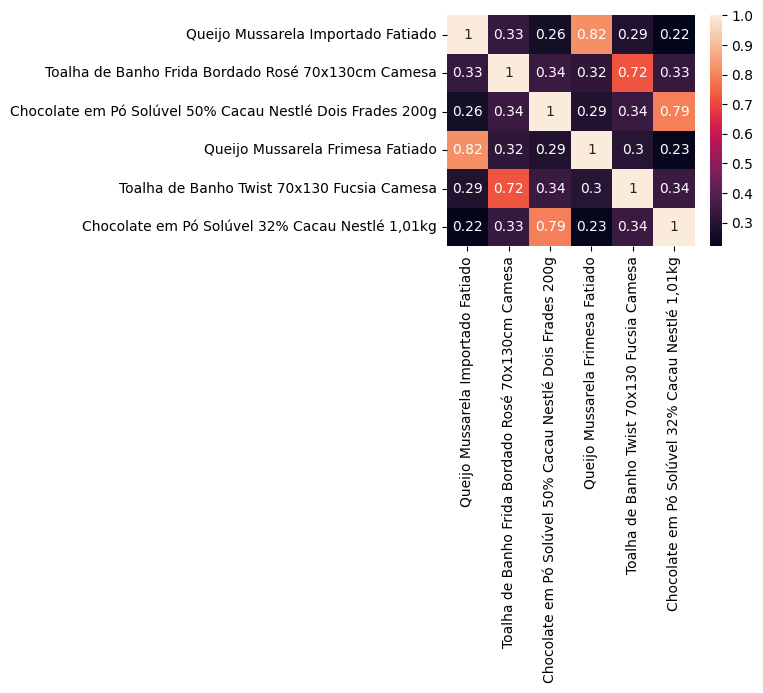

In [14]:
similarity_matrix_example = np.array(
    [
        [sim_matrix[id1][id2]/100 for id1 in random_ids]
        for id2 in random_ids
    ]
)
labels = [texts[id] for id in random_ids]

fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(similarity_matrix_example, annot=True, xticklabels = labels, yticklabels=labels, ax=ax)

In [15]:
# # RESCALE SIMILARITY MATRIX TO [0,1]
# sim_matrix = sim_matrix / 100

## Try simple clustering

### Idea 1 (Greedy)

**Input**: 
- similarity matrix NxN (ideally with similarity zero for products of same market)
- similarity threshold (> 0)
- dictionary id2market linking products IDs to their market id.

**Output**: 
- list or dict associating each product/node to a cluster number

**Algorithm**:

Start with greatest similarities and do the following:
- if the edge weight (i.e., the similarity) is smaller than threshold, stop loop \
  Alternatively, do this filter before sorting list of edges to visit in decreasing order of similairty (we must do a sort anyway...)
- if both nodes already belong to some cluster, skip
- if u is in cluster k and v has no cluster, add v to cluster k but only if v's market is not represented in that lister
- if none have a cluster, build a new cluster and add both

In the end, add all orphan products to their own cluster.

Needless to say that all edges must connect product from different markets...


First, force similarity to be zero for products in same market

In [16]:
from tqdm import tqdm

for id_list in market2id.values():
    for id1 in tqdm(id_list):
        for id2 in id_list:
            sim_matrix[id1][id2] = 0

  0%|          | 0/9443 [00:00<?, ?it/s]

100%|██████████| 10356/10356 [00:24<00:00, 417.35it/s]


Do clustering

In [17]:
from numba import njit

In [18]:
@njit(parallel=True)
def build_edge_list(matrix, thres):
    fair_sz = max(1, len(matrix) ** 2 // 1000)  # assume each product has similarity > threshold for less then 0.1% of all products
    leftnodes = np.ones(fair_sz)
    rightnodes = np.ones(fair_sz)
    similarities = np.ones(fair_sz)
    k = 0
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if j <= i:
                continue
            val = matrix[i][j]
            if val >= thres:
                leftnodes[k] = i
                rightnodes[k] = j
                similarities[k] = val
                k += 1
                if k > fair_sz:
                    raise RuntimeError(f"k = {k}, increase fair-sz in build_edge_list(..)")
    return leftnodes, rightnodes, similarities

In [19]:
# call njit-annotated function with small example so numba compiles tha function
build_edge_list(np.array([[1]]), 70)

(array([1.]), array([1.]), array([1.]))

In [20]:
build_edge_list(sim_matrix, 70)

(array([0., 0., 0., ..., 1., 1., 1.]),
 array([9.732e+03, 9.736e+03, 9.745e+03, ..., 1.000e+00, 1.000e+00,
        1.000e+00]),
 array([100.,  85.,  79., ...,   1.,   1.,   1.]))

In [21]:
# %%time

thres = 70  # similarity threshold (only similarities greater than that are considered)
N = len(data)
assert sim_matrix.shape == (N, N)
n_clusters = 0
print("array of products' clusters")
clusters = - np.ones(N, dtype=int) # clusters[prod of id N] is the cluster number
                               #! CONVENTION: VALID CLUSTER NUMBERS STARTING AT 0
cluster2markets = {}  # cluster number: list of markets present in cluster

print("building list to sort")
leftnodes, rightnodes, similarities = build_edge_list(sim_matrix, thres)
edges = [(int(l),int(r),s) for l,r,s in zip(leftnodes, rightnodes, similarities)]

print(f"sorting valid edges (total of edges: {len(edges)})")
edges = sorted(edges, key=lambda t: t[2], reverse=True)

print("building clusters")
for e in tqdm(edges):
    # if both nodes already have a cluster, skip edge
    if clusters[e[0]] != -1 and clusters[e[1]] != -1:
        continue
    # if only one of the nodes has a cluster and the market of the other node is not yet 
    # represented in the cluster, add that unclustered node to the node
    if clusters[e[1]] != -1 and id2market[e[0]] not in cluster2markets[clusters[e[1]]]:
        clusters[e[0]] = clusters[e[1]]
        cluster2markets[clusters[e[1]]].append(id2market[e[0]])
        continue
    if clusters[e[0]] != -1 and id2market[e[1]] not in cluster2markets[clusters[e[0]]]:
        clusters[e[1]] = clusters[e[0]]
        cluster2markets[clusters[e[0]]].append(id2market[e[1]])
        continue
    # if both don't have a cluster, create new cluster and add both
    # NOTE: since entries for same market have been zeroed-out before starting the algorithm
    # and threshold > 0, then we know e[0] and e[1] are from different markets
    cluster = n_clusters
    n_clusters += 1
    clusters[e[0]] = cluster
    clusters[e[1]] = cluster
    cluster2markets[cluster] = [id2market[e[0]], id2market[e[1]]]

# do cluster for remaining products
for i, val in enumerate(clusters):
    if val == -1:
        clusters[i] = n_clusters
        n_clusters += 1

array of products' clusters
building list to sort
sorting valid edges (total of edges: 1813141)
building clusters


100%|██████████| 1813141/1813141 [00:01<00:00, 1497029.72it/s]


### Explore generated clusters

number of clusters

In [22]:
max(clusters) + 1 # nb clusters

25113

distribution of cluster sizes

c:\Users\danie\miniconda3\envs\csi28\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\danie\miniconda3\envs\csi28\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

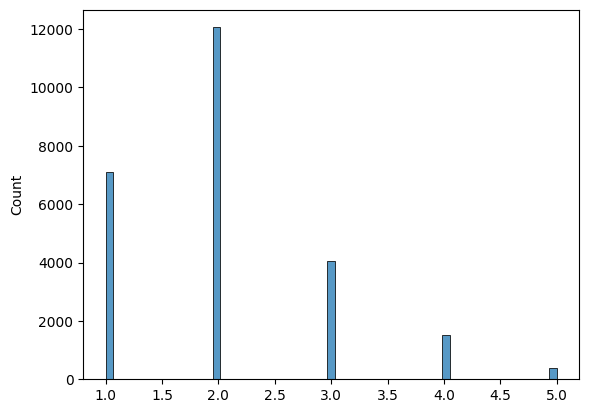

In [23]:
cluster_sizes = [len(val) for val in cluster2markets.values()] + \
                [1 for _ in range(max(clusters) - len(cluster2markets))]
                # this 2nd term is because singletons (clusters of 1 elem) are not in clisters2markets
sns.histplot(cluster_sizes)

sample some clusters

In [24]:
for cluster in np.random.choice(max(clusters), 10):
    products_ids = [i for i, c in enumerate(clusters) if c == cluster]
    print(f"Cluster #{cluster}:")
    for pid in products_ids:
        print("\t" + texts[pid])

Cluster #16959:
	Coalhada Natural Integral Carrefour 170g
	Coalhada Integral Taeq 160g
Cluster #19175:
	Álcool em Gel Luar Mágico 70º Embalagem 500g
Cluster #24478:
	Mostarda Tipo Dijon Qualitá 220g
Cluster #17628:
	Lasanha À Bolonhesa Aurora 600g
	Lasanha a Bolonehsa Carrefour
Cluster #15011:
	Queijo Gorgonzola Vigor 100g
Cluster #3255:
	Chocottone Casa D'oro 400g
Cluster #19867:
	Kit Escolar Ecolápis Faber Castell com 16 Peças
Cluster #11966:
	Refrigerante de Guaraná Tubaína Sukita 350ml
Cluster #15094:
	Salsicha Sadia Tradicional 500g
	Sal Parrila Tradicional Dia 500g
Cluster #9161:
	Cápsula Nespresso Cerrado Mineiro Três Corações 5g com 10un
	Cápsula Nespresso Cerrado Mineiro Três Corações 5g com 10un


Minimum similarity within clusters

In particular for greedy approaches, we may have elements that are not so similar within same cluster.. (bad)

In [25]:
from itertools import combinations

In [32]:
min_sims_in_cl = []

for cluster in tqdm(np.random.choice(max(clusters), 5000)):
    products_ids = [i for i, c in enumerate(clusters) if c == cluster]
    min_sim = 999999
    for p1, p2 in combinations(products_ids, 2):
        if sim_matrix[min(p1, p2)][max(p1, p2)] < min_sim:
            min_sim = sim_matrix[min(p1, p2)][max(p1, p2)]
    if min_sim < 999999:  # can be == 999999 for clusters of 1 element (singletons)
        min_sims_in_cl.append(min_sim)

100%|██████████| 5000/5000 [00:24<00:00, 202.29it/s]


In [33]:
len(min_sims_in_cl)

2594

c:\Users\danie\miniconda3\envs\csi28\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\danie\miniconda3\envs\csi28\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

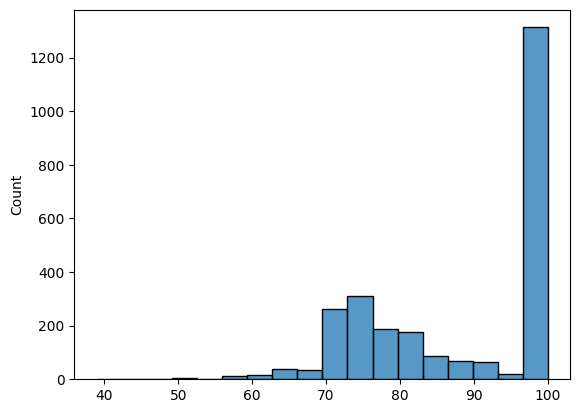

In [34]:
sns.histplot(min_sims_in_cl)

In [39]:
f"{100*sum([x < 70 for x in min_sims_in_cl])/len(min_sims_in_cl)}% clusters with a pair of elements with a similarity under 70%"

'4.2020046260601385% clusters with a pair of elements with a similarity under 70%'